### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

This generation of ld-decode uses FFT multiplication to perform convolutions. This allows multiple filter types to be "stacked" into a minimal number of general operations.

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [11]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    tdangles2[tdangles2 < 0] += tau
    tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [12]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [13]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [14]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [16]:
# nice GGV sample (40msps)
#infile = open('ggv1069_22000.raw', 'rb')

# discovision logo (rotted :P )
#infile = infile = open('/home/cpage/erica_44a.raw', 'rb')
#infile.seek(1024 * 1024 * 1400)

infile = infile = open('/home/cpage/rotplane44_otto.raw', 'rb')

#infile = infile = open('/home/cpage/ve22_44zonea.raw', 'rb')

inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [17]:
blockcut = 1024

params['freq'] = 44.0
params['deemp'] = (120*.65, 320*.65)
filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=True)


In [18]:
output

array([ 8268656.52994886,  8232783.02497182,  8136748.82281681, ...,
        8255728.02217749,  8269363.82834906,  8275458.37222643])

Below this is the less developed code to deal with NTSC framing and syncs.

In [19]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

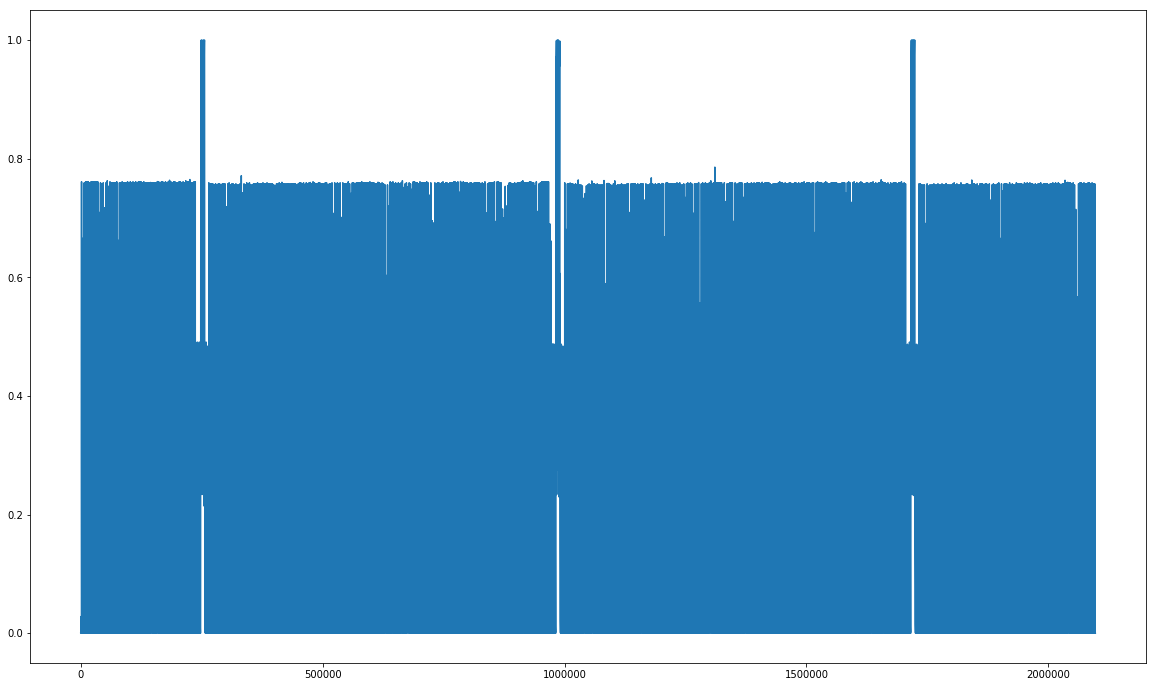

In [20]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [21]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 400000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen]) + loc

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

985943

In [22]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_syncf, syncloc)

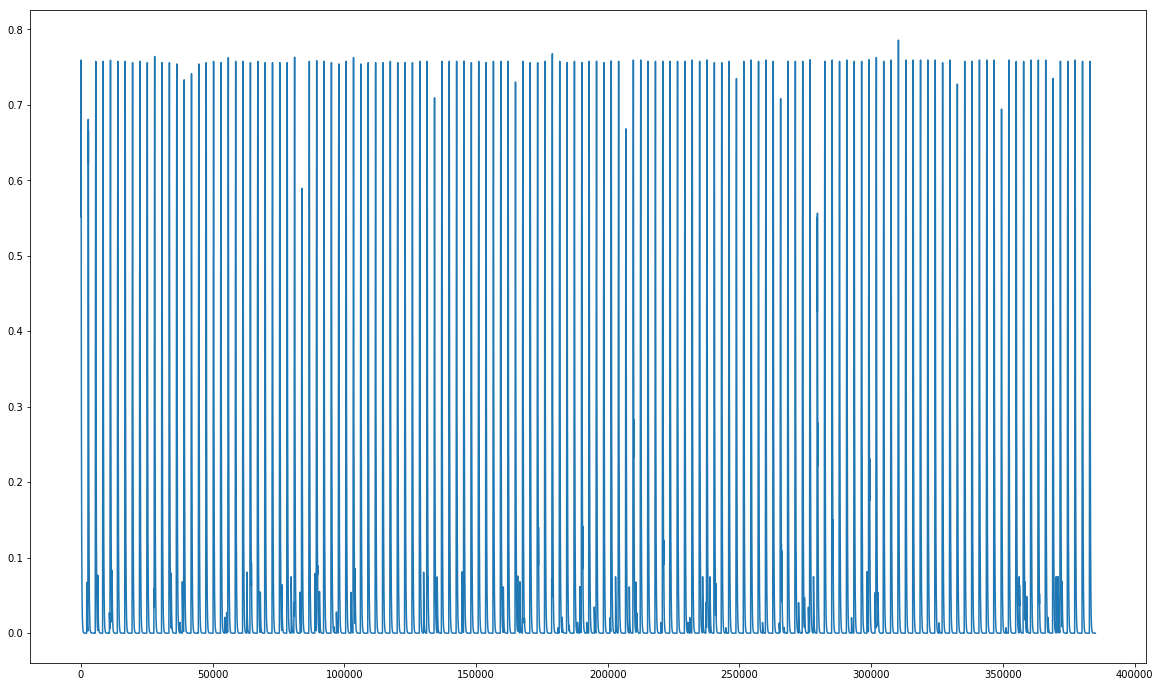

In [23]:
plt.plot(output_syncf[nextline:syncloc+399430])

In [24]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [25]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

1003081 7455766.92006 8526011.31308
1005916 7773122.25745 8153302.41812
1008711 7774915.65143 8189442.97145
1011507 7783961.84506 8139528.04322
1014303 7778833.67431 8182609.03045
1017099 7772758.98025 8181284.26435
1019894 7777104.11479 8176920.39127
1022690 7767386.29493 8168885.13326
1025486 7782175.64401 8177838.60388
1028281 7757799.6657 8210746.7255
1031077 7757032.41005 8248849.49297
1033873 7763202.98229 8160600.63536
1036668 7738713.85516 8117094.95099
1039465 7795576.05354 8145909.16131
1042260 7741318.82797 8188549.14498
1045055 7723148.75146 8111520.73315
1047852 7757010.94634 8183244.76547
1050648 7795762.44081 8187045.51034
1053443 7758328.95322 8191084.16861
1056239 7753675.82982 8136304.22613
1059035 7771604.89434 8147275.73589
1061831 7784048.61586 8177645.07688
1064626 7726064.543 8178945.61203
1067422 7739726.49267 8168577.80107
1070218 7761141.82304 8144094.59955
1073013 7738761.44313 8146969.1206
1075809 7757873.25316 8146519.19752
1078605 7796400.19555 8152319.991

In [26]:
m20ire = 8100000-hz_ire_scale*20

In [27]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [28]:
video_05 = filtfft(sps.butter(3, 0.5/22, 'low'))
output_lp = np.fft.ifft(np.fft.fft(output) * video_05).real[29:] 

In [29]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


1005916 7773122.25745 7840440.69049 7922495.95444
1008711 7774915.65143 7831520.20938 7900236.39538
1011507 7783961.84506 7840440.60768 7909939.01475
1014303 7778833.67431 7831375.85618 7903668.97163
1017099 7772758.98025 7842980.76776 7924661.48168
1019894 7777104.11479 7843951.00375 7913872.29833
1022690 7767386.29493 7820199.38431 7886134.51191
1025486 7782175.64401 7840683.44574 7912177.85237
1028281 7757799.6657 7800158.2472 7845823.87017
1031077 7757032.41005 7802667.01048 7858400.30753
1033873 7763202.98229 7826757.21778 7897336.93171
1036668 7738713.85516 7798642.23969 7864159.97253
1039465 7795576.05354 7848282.69448 7907545.3624
1042260 7741318.82797 7803078.45239 7875546.33429
1045055 7723148.75146 7797823.43354 7878696.27788
1047852 7757010.94634 7814244.21448 7887702.21088
1050648 7795762.44081 7854073.52304 7917833.54208
1053443 7758328.95322 7805741.17637 7868847.42602
1056239 7753675.82982 7820192.80118 7897794.14659
1059035 7771604.89434 7823944.15809 7885869.8008
1061

In [30]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output_lp, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


1005916 1000238 1000238 7773122.25745 7840440.69049 7922495.95444
1008711 1003081 1003081 7774915.65143 7831520.20938 7900236.39538
1011507 1005916.00115 1008514.18082 7783961.84506 7840440.60768 7909939.01475
1014303 1008710.99794 1011310.12128 7778833.67431 7831375.85618 7903668.97163
1017099 1011506.82372 1014105.60926 7772758.98025 7842980.76776 7924661.48168
1019894 1014302.5248 1016901.12587 7777104.11479 7843951.00375 7913872.29833
1022690 1017098.62113 1019697.31774 7767386.29493 7820199.38431 7886134.51191
1025486 1019894.18627 1022492.92959 7782175.64401 7840683.44574 7912177.85237
1028281 1022690.20597 1025288.39704 7757799.6657 7800158.2472 7845823.87017
1031077 1025486.10589 1027957.89457 7757032.41005 7802667.01048 7858400.30753
1033873 1028281.71521 1030880.77541 7763202.98229 7826757.21778 7897336.93171
1036668 1031076.83465 1033676.59918 7738713.85516 7798642.23969 7864159.97253
1039465 1033873.17826 1036471.96993 7795576.05354 7848282.69448 7907545.3624
1042260 103666

In [31]:
# experiment:  filter color burst data for easier alignment

In [32]:
video_cburst = filtfft(sps.butter(2, [(300/88.0)/22, (330/88.0)/22], 'bandpass'))


In [33]:
output_cburst = np.fft.ifft(np.fft.fft(output - 8100000) * video_cburst).real[98:] + 8100000

In [34]:
calczc(output_lp, int(lineinfo2[250])-80, m20ire, 200), calczc(output, int(lineinfo2[250])-80, m20ire, 200)

(1699128.0943013444, 1699129.33502193)

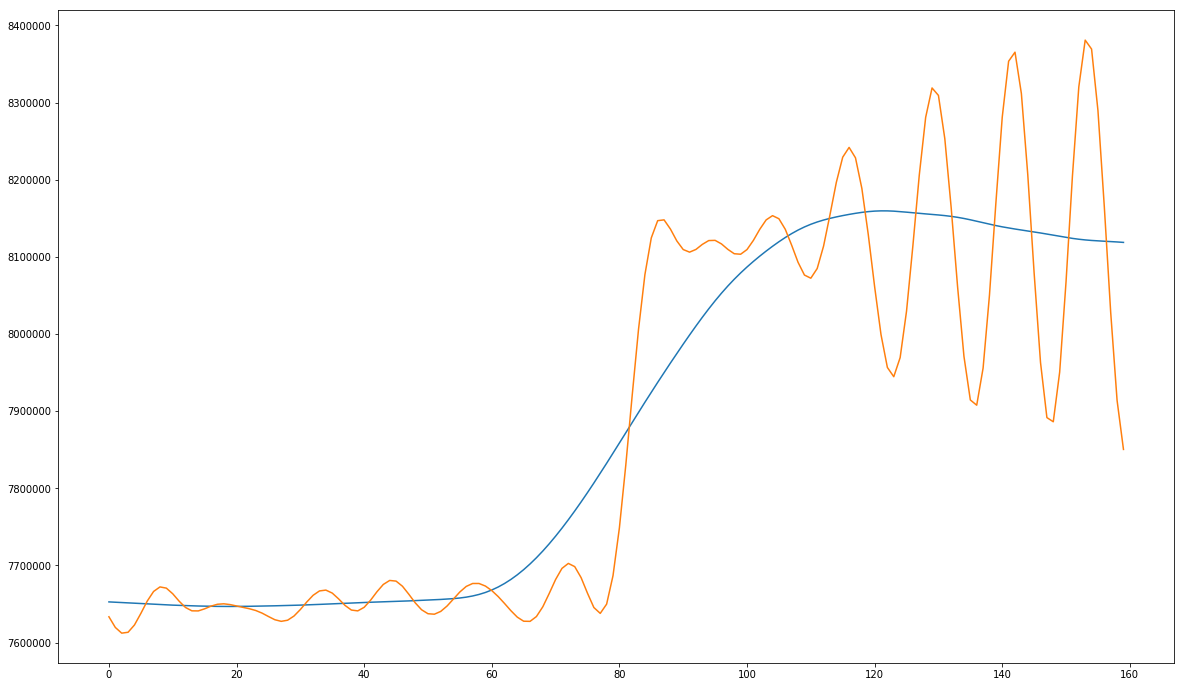

In [35]:
plt.plot(output_lp[int(lineinfo2[250]-80):int(lineinfo2[250])+80])
plt.plot(output[int(lineinfo2[250])-80:int(lineinfo2[250])+80])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

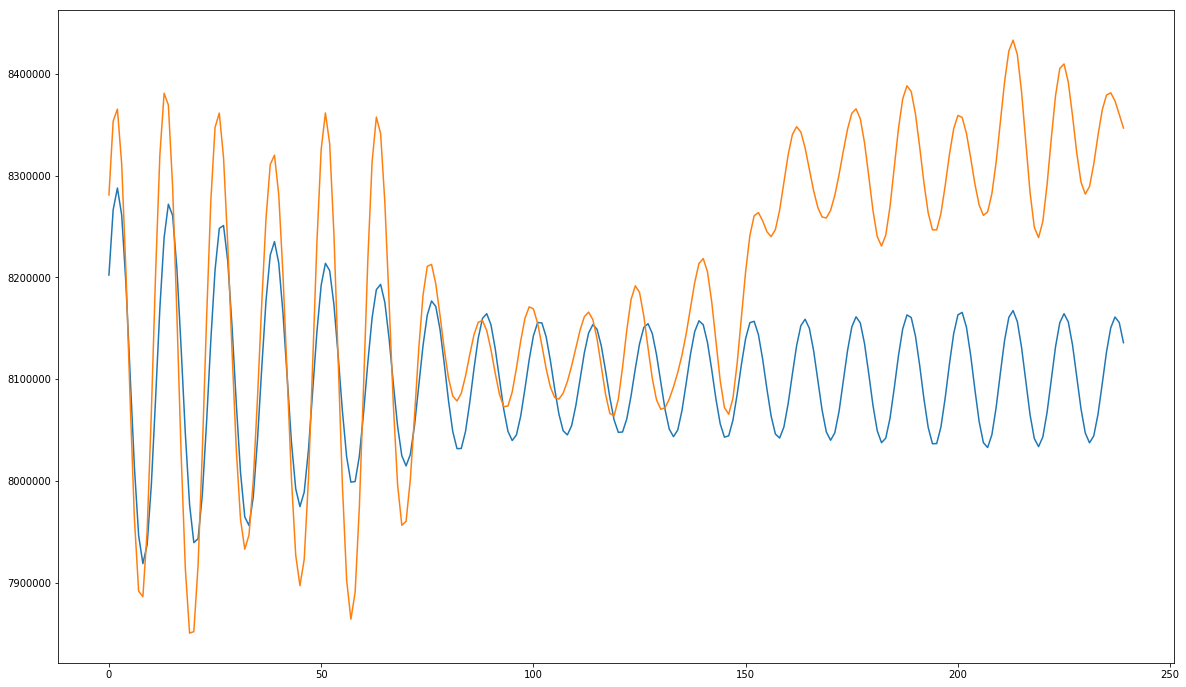

In [36]:
plt.plot(output_cburst[int(lineinfo2[250]+60):int(lineinfo2[250])+300])
plt.plot(output[int(lineinfo2[250])+60:int(lineinfo2[250])+300])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

In [38]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


1005916 7773122.25745 7840440.69049 7922495.95444
1008711 7774915.65143 7831520.20938 7900236.39538
1011507 7783961.84506 7840440.60768 7909939.01475
1014303 7778833.67431 7831375.85618 7903668.97163
1017099 7772758.98025 7842980.76776 7924661.48168
1019894 7777104.11479 7843951.00375 7913872.29833
1022690 7767386.29493 7820199.38431 7886134.51191
1025486 7782175.64401 7840683.44574 7912177.85237
1028281 7757799.6657 7800158.2472 7845823.87017
1031077 7757032.41005 7802667.01048 7858400.30753
1033873 7763202.98229 7826757.21778 7897336.93171
1036668 7738713.85516 7798642.23969 7864159.97253
1039465 7795576.05354 7848282.69448 7907545.3624
1042260 7741318.82797 7803078.45239 7875546.33429
1045055 7723148.75146 7797823.43354 7878696.27788
1047852 7757010.94634 7814244.21448 7887702.21088
1050648 7795762.44081 7854073.52304 7917833.54208
1053443 7758328.95322 7805741.17637 7868847.42602
1056239 7753675.82982 7820192.80118 7897794.14659
1059035 7771604.89434 7823944.15809 7885869.8008
1061

In [39]:
# now to get fine sync!

In [40]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [41]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [42]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [43]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [44]:
def calcerr(line):
    subset = line[5:60]
    
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [45]:
910 * 1.2

1092.0

In [52]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
finalsnr = []

# because of odd issues, it makes sense to do one line and the next burst together, and so on...
for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        offset1 = calcerr(scaled[0:60])
        offset2 = calcerr(scaled[910:970])
        print(l, i, offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if (i == 0):
            lineinfo_tmp[l + 1] += ((offset2 - offset1) * (linelen / 910) * (0.83 / (i + 1)))
        else:
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * (.4 / (i + 1)))
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * (.4 / (i + 1)))
            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 1.58586927879 -0.0243606850876 22.5085040554
1 1 1.62259606944 0.0252177029945 22.8054303355
1 2 1.2745112108 0.0300428576071 21.4544609376
1 3 1.43228524401 0.0630053969701 20.8322213058
1 4 1.47695684225 0.0612880921701 20.3899036572
1 f 1.325138926 0.0601523731972 20.0795421289
2 0 0.0147549005936 0.0424624853675 21.8369090814
2 1 0.0141103179311 0.0232518022598 21.703900318
2 2 0.0117409553131 0.0432779108968 21.693451705
2 3 0.0103383565009 0.0384786451303 21.6696469837
2 4 0.00941147363854 0.0352748481411 21.6538002714
2 f 0.00873611068539 0.0329232470092 21.6421914423
3 0 0.0393093609023 0.0492466700395 34.0572128999
3 1 0.0390908109796 0.0422848279176 34.1063203852
3 2 0.0327516872438 0.060434606572 34.1073621473
3 3 0.029120394603 0.053768423931 34.1244135301
3 4 0.0266976711249 0.0578631784005 34.1346538732
3 f 0.0249019107332 0.0540237443093 34.1443137885
4 0 0.0553791734576 -0.00405533309457 35.7393996954
4 1 0.0566468254115 0.0388646891086 35.20116908
4 2 0.04749399086

39 4 0.0197122217745 0.149899369201 33.1736365981
39 f 0.0181908390792 0.175933019736 32.943411836
40 0 0.142797699717 0.128523253329 35.8157967161
40 1 0.143153144443 0.139644474554 35.8497002362
40 2 0.259996666364 0.239539232712 35.8491315106
40 3 0.286842671161 0.208369018823 35.8508502204
40 4 0.258216764661 0.187343024208 35.8503144108
40 f 0.236671418951 0.171379936057 35.8419761183
41 0 0.175409119296 -0.0133696763356 30.9101385129
41 1 0.180490586745 0.010939326115 28.2648157453
41 2 0.141239006645 0.0100542162298 27.7720412845
41 3 0.119966338686 0.00942639740376 27.5282125836
41 4 0.106093608132 0.00895260814866 27.3776234266
41 f 0.0961557642589 0.00857636307086 27.273343808
42 0 -0.0041703186702 0.000476838490806 33.1003535441
42 1 -0.00427020281959 -0.00285438949634 33.0119914613
42 2 -0.00359185556571 -0.00238446870824 33.0055500815
42 3 -0.00321141264182 -0.0021229281896 33.0018882358
42 4 -0.0029562818197 -0.00194835472321 32.999412411
42 f -0.00276838193723 -0.0018202

75 1 3.20787968009 0.0431275778948 14.906343954
75 2 4.20064015765 0.0571320446421 14.0104626617
75 3 4.03032458318 0.0691963486633 13.1118705161
75 4 4.31805462893 0.0766132374685 12.4739040726
75 f 3.94004873422 0.058985005865 11.9832706306
76 0 0.0767738122405 0.180555506718 21.0893094783
76 1 0.0731411858787 0.133156768348 21.4896654888
76 2 0.0570717548978 0.100609513646 21.5491844545
76 3 0.0486889109248 0.117893832192 21.5783212308
76 4 0.0431699120247 0.102075815008 21.6134122359
76 f 0.0392531206758 0.0907783122657 21.6374927917
77 0 0.118168962079 0.106073062494 36.0174307268
77 1 0.118497258356 0.0806016419638 35.8374125159
77 2 0.13607169011 0.101140898008 35.6955471112
77 3 0.114831168856 0.171417377399 35.6054866752
77 4 0.100737287269 0.155309645636 35.7175197205
77 f 0.0906639385538 0.175932532576 35.8016497896
78 0 0.176306943699 0.0838916239078 33.7110652003
78 1 0.178727029908 -0.0216570374592 32.71079949
78 2 0.192450147461 -0.0169990661201 32.0517961
78 3 0.2227499

116 2 0.0603510609206 0.0567929042378 35.9188857025
116 3 0.0491782163662 0.0459165507912 35.9175412719
116 4 0.0423276193953 0.039266823907 35.9165785753
116 f 0.0376114661654 0.0347004593067 35.9158358612
117 0 0.0356693319938 0.181853918528 35.8873561967
117 1 0.0304587733166 0.0160844596745 37.3418544616
117 2 0.021733218281 0.0113965684636 37.3611393588
117 3 0.0176356022136 0.00917868230371 37.3693616893
117 4 0.0151437178194 0.00783817608901 37.3740770282
117 f 0.0134326525985 0.00692197194606 37.3771886245
118 0 0.0254509496221 0.0103350240679 29.0812881584
118 1 0.0260438927115 0.00188847596666 28.8803961211
118 2 0.0185500447713 0.00171547052627 28.8016660915
118 3 0.014979025511 0.00158950141456 28.7652600811
118 4 0.012811902219 0.00149508234854 28.7435929769
118 f 0.0113269438554 0.00142084975566 28.7289625685
119 0 0.0457944418903 0.183340617672 31.5544906099
119 1 0.0421219534039 0.0387028259091 29.3781494273
119 2 0.0346707867666 0.0283401549199 29.3839741433
119 3 0.03

156 3 -0.00111521853334 0.0194641216701 37.8619365509
156 4 -0.0010502773757 0.0168522531122 37.8600890459
156 f -0.000996676675468 0.0150464131093 37.8579557555
157 0 0.0182305662031 0.182452343335 34.3081938912
157 1 0.0129929274253 0.00825040727076 35.7412447984
157 2 0.00966620928791 0.00613488923174 35.7428263802
157 3 0.00801975694067 0.00508502222147 35.7435425987
157 4 0.00699641087763 0.00443200184301 35.7439658495
157 f 0.00628272552557 0.0039772733973 35.7442511472
158 0 0.0122451861695 0.259056574794 34.0015779844
158 1 0.00360976583297 0.00300063541895 38.8519804985
158 2 0.0026712045957 0.00221205489926 38.8522049427
158 3 0.00220811746518 0.00182455696475 38.8523144449
158 4 0.00192099191697 0.0015848649949 38.8523819225
158 f 0.00172115052695 0.00141831239538 38.8524287039
159 0 0.0118072494241 0.180557174044 35.912825611
159 1 0.0060374958615 -0.0117992779482 39.1073432907
159 2 0.0045854311606 -0.00844202709242 39.1111547057
159 3 0.00384736155656 -0.00683778284882 39

197 4 -0.00489555962074 -0.0101108306531 38.0243753551
197 f -0.00433758848079 -0.00896442412667 38.0266665968
198 0 -0.00613321813493 0.143018539141 36.6072316805
198 1 -0.0114747570627 -0.0262010257023 39.2023763886
198 2 -0.00814368991826 -0.0189633382955 39.215919872
198 3 -0.00656415083456 -0.0154574344754 39.2208139825
198 4 -0.00560793693604 -0.013293051214 39.2232585805
198 f -0.00495383828533 -0.0117891102685 39.2246927925
199 0 -0.00919238239867 0.115999406254 37.1946877167
199 1 -0.0136105497596 -0.0262044248784 37.9506386953
199 2 -0.00971670686565 -0.0190706334372 37.9808529239
199 3 -0.00785696714304 -0.0156043751986 37.9949604307
199 4 -0.00672770392531 -0.013475268195 38.0034358086
199 f -0.00595346536146 -0.0120034530368 38.0092097405
200 0 -0.00283203709942 0.137213822054 36.4233140589
200 1 -0.00781812150199 -0.0197438489854 37.7178608195
200 2 -0.00561203524426 -0.0145839518654 37.7289202308
200 3 -0.00455338311089 -0.0120327281427 37.7338119784
200 4 -0.00390812411

240 f -0.00237718082335 -0.00259091423139 34.5885811054
241 0 0.0026576578266 0.113975140514 34.9785230658
241 1 -0.000652373583829 -0.0210714437718 35.2005213193
241 2 -0.000349326332406 -0.0149521139736 35.2269878508
241 3 -0.00022360978106 -0.012053855577 35.2384730911
241 4 -0.00015435600842 -0.0103002493612 35.2450911326
241 f -0.000110435621212 -0.009100863941 35.2494735999
242 0 -0.00677350176288 0.168335727168 33.6851887167
242 1 -0.0133697880868 -0.0240238114007 34.7800243884
242 2 -0.00950101859401 -0.0176800673523 34.7895210658
242 3 -0.00766311266615 -0.0145547021295 34.7941131623
242 4 -0.00654952874105 -0.0126205615588 34.7969200852
242 f -0.00578725336008 -0.0112767938217 34.7988539474
243 0 -0.00455903969253 0.015671744301 38.7299304243
243 1 -0.00521960519272 -0.00621012174446 38.7979677427
243 2 -0.00384890385926 -0.00463298692173 38.797717173
243 3 -0.00317443615748 -0.00384769037164 38.7975867482
243 4 -0.00275700517394 -0.00335823907318 38.7975032142
243 f -0.00246

In [53]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr)

(32.917708158015564, 10.308392964592564, 201)

In [54]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 2.3505976384 (1000238, 1003081)
1 0.0189921876881 (1003083.3505976384, 1005911.9004472892)
2 0.0529435265344 (1005911.9194394769, 1008711.1212504312)
3 0.0768443169072 (1008711.1741939577, 1011506.9305381891)
4 0.0243031251011 (1011507.007382506, 1014302.4257570435)
5 0.021259393543 (1014302.4500601686, 1017098.632947839)
6 0.0156150410185 (1017098.6542072325, 1019894.2630019368)
7 0.00907156534959 (1019894.2786169779, 1022690.1999476926)
8 -0.00454316381365 (1022690.2090192579, 1025486.0246830392)
9 -0.0327326379484 (1025486.0201398754, 1028281.5830591816)
10 0.110529193305 (1028281.5503265436, 1031077.0693270559)
11 0.09896227438 (1031077.1798562492, 1033873.2474694236)
12 5.37163061078 (1033873.346431698, 1036683.975662975)
13 0.275527338614 (1036689.3472935858, 1039456.0688452583)
14 -0.0171120591694 (1039456.3443725969, 1042259.8452936605)
15 -0.00814499286935 (1042259.8281816014, 1045056.1225240533)
16 0.0193405997707 (1045056.1143790605, 1047852.0584454254)
17 0.202773512574 (

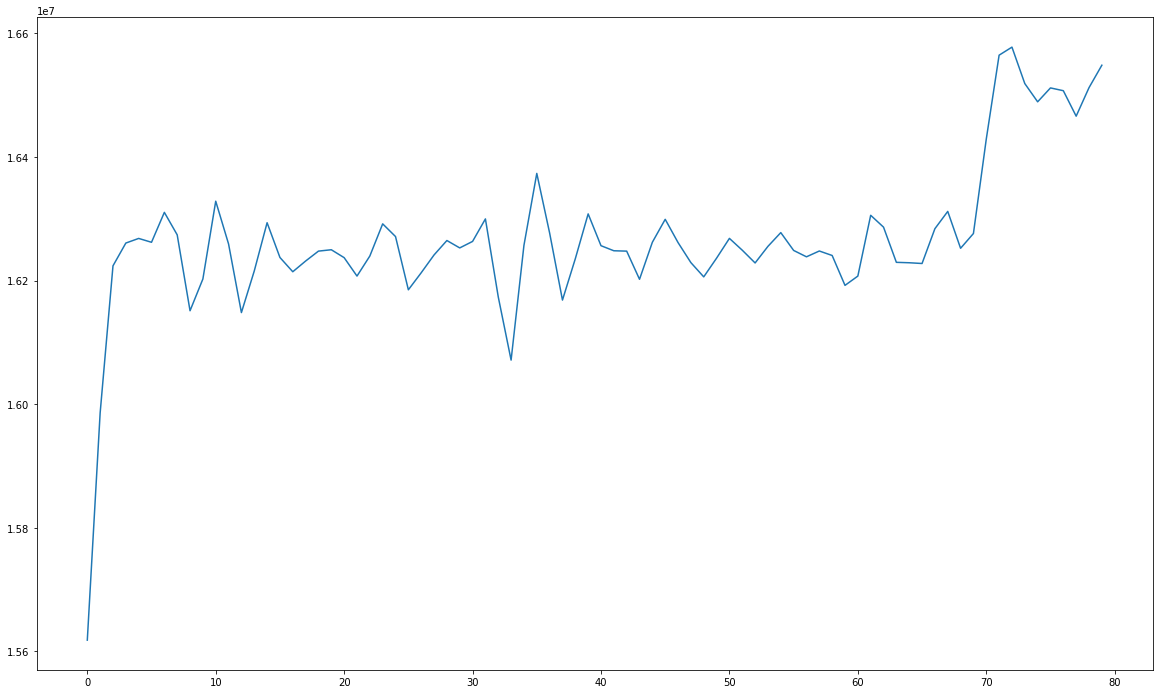

In [56]:
l1 = 153
#plt.plot(lines[(l1 * 910):(l1 * 910) + 80])
l2 = 154
#plt.plot(lines[(l2 * 910):(l2 * 910) + 80])
plt.plot(lines[(l1 * 910):(l1 * 910) + 80] + lines[(l2 * 910):(l2 * 910) + 80])

32.917708158
(230230,)
uint8 (253, 910) (253, 910)


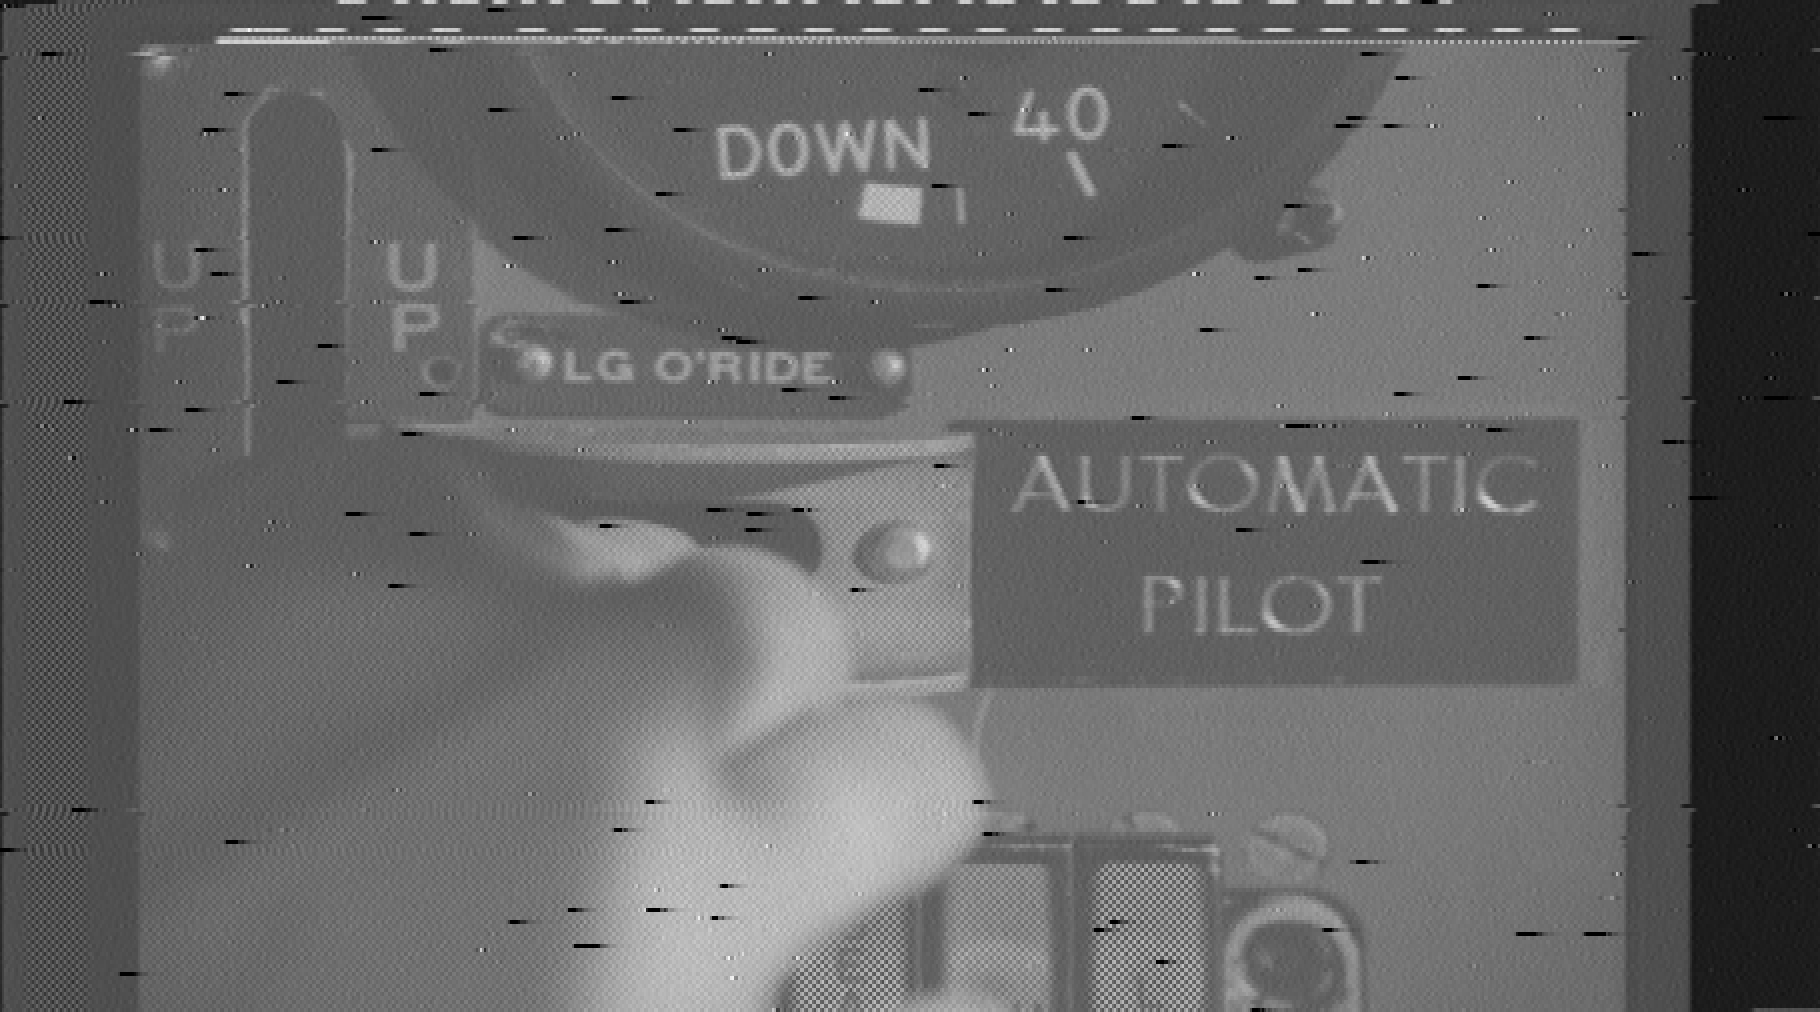

In [55]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

(230230,)
uint8 (253, 910) (253, 910)


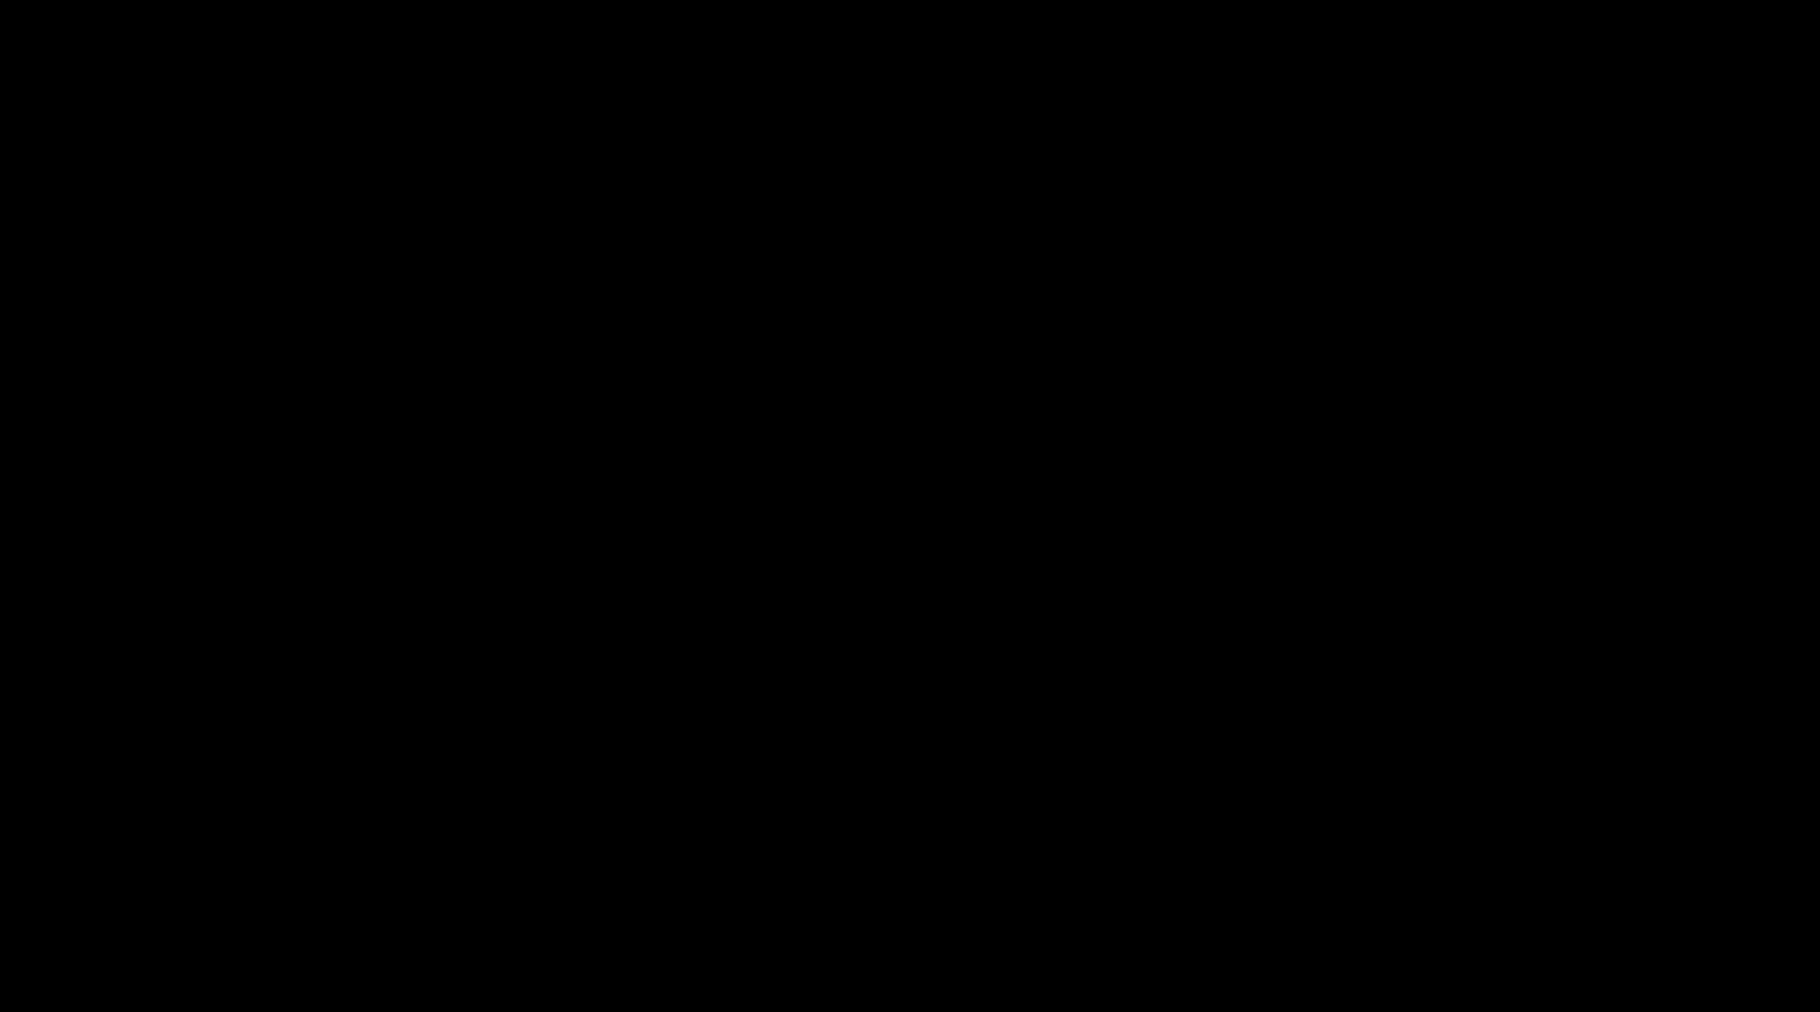

In [59]:
def downscale2(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l][0], lineinfo[l + 1][1], 910)
        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout

lines, downscale2(output_cburst, lineinfo3)
    
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
drawdata(lines16, 910, len(lineinfo3)-1, hscale=2, vscale=4)

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

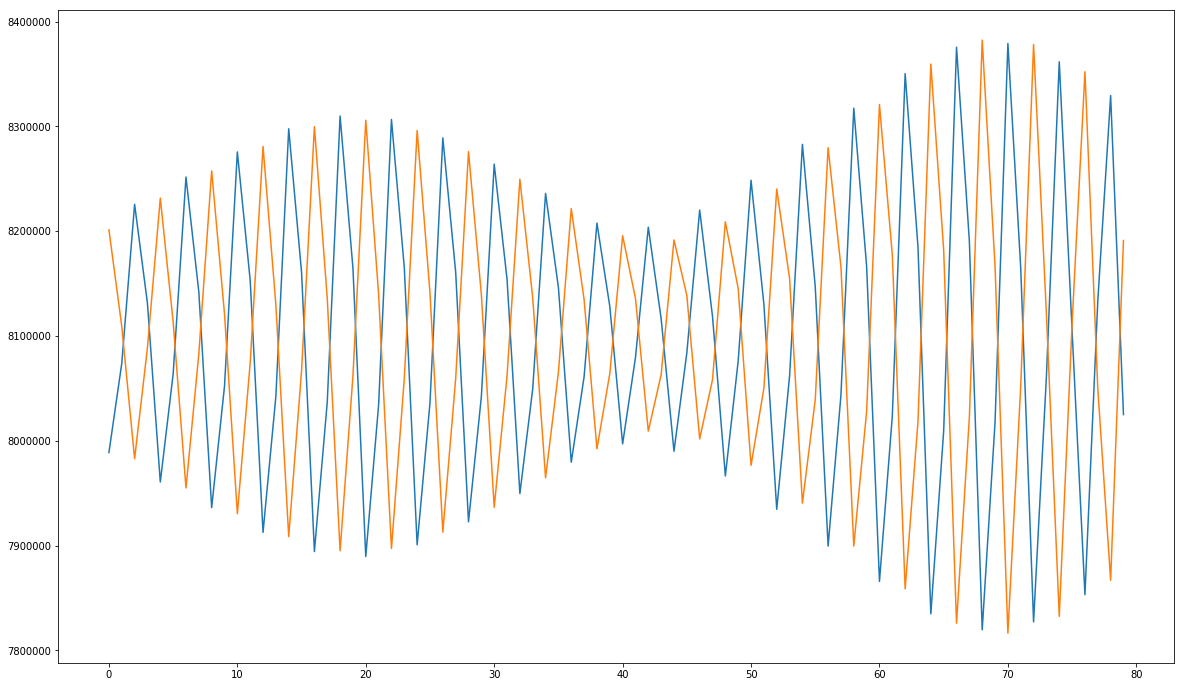

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

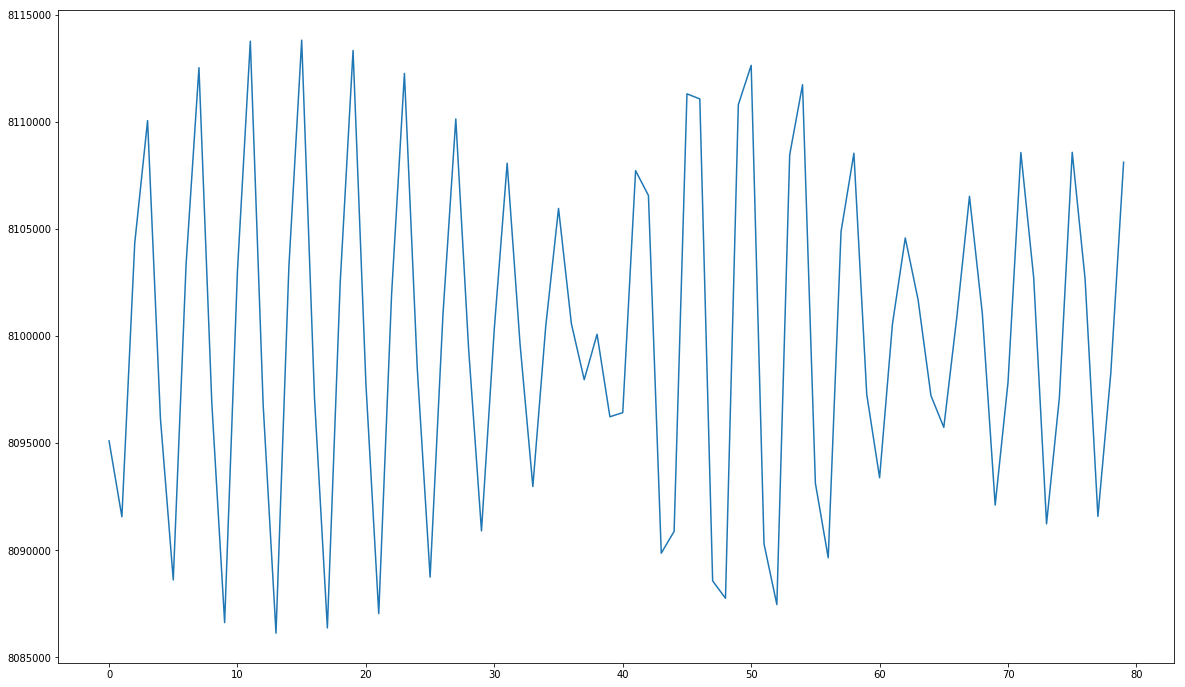

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


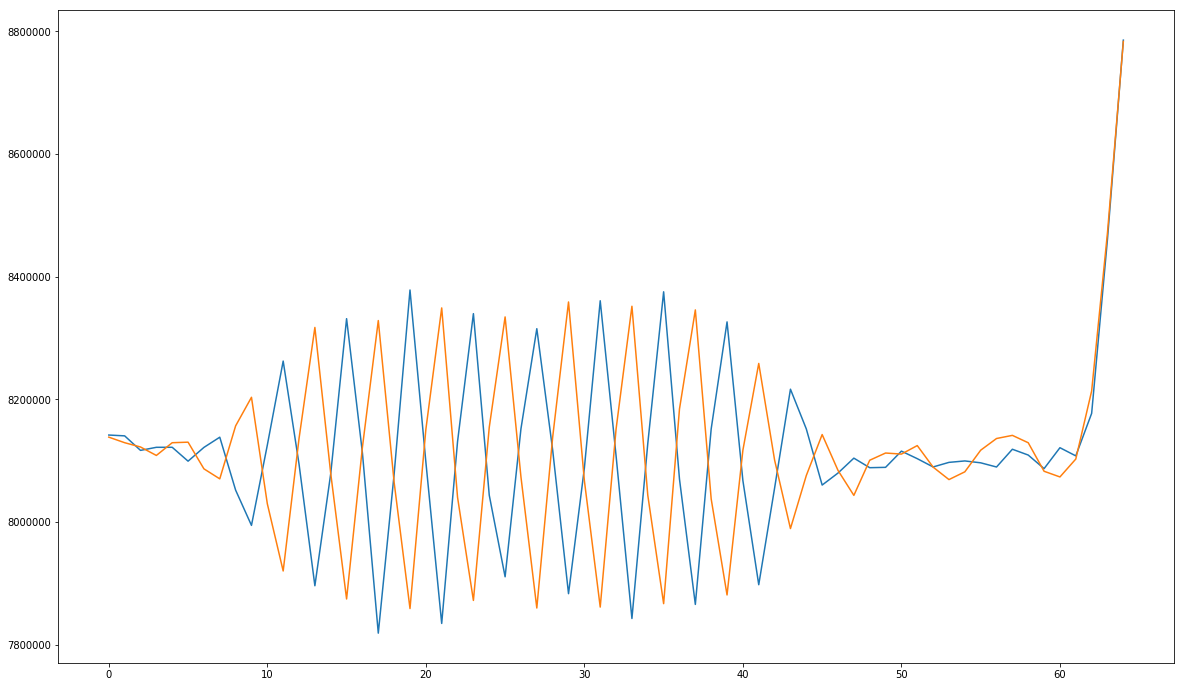

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


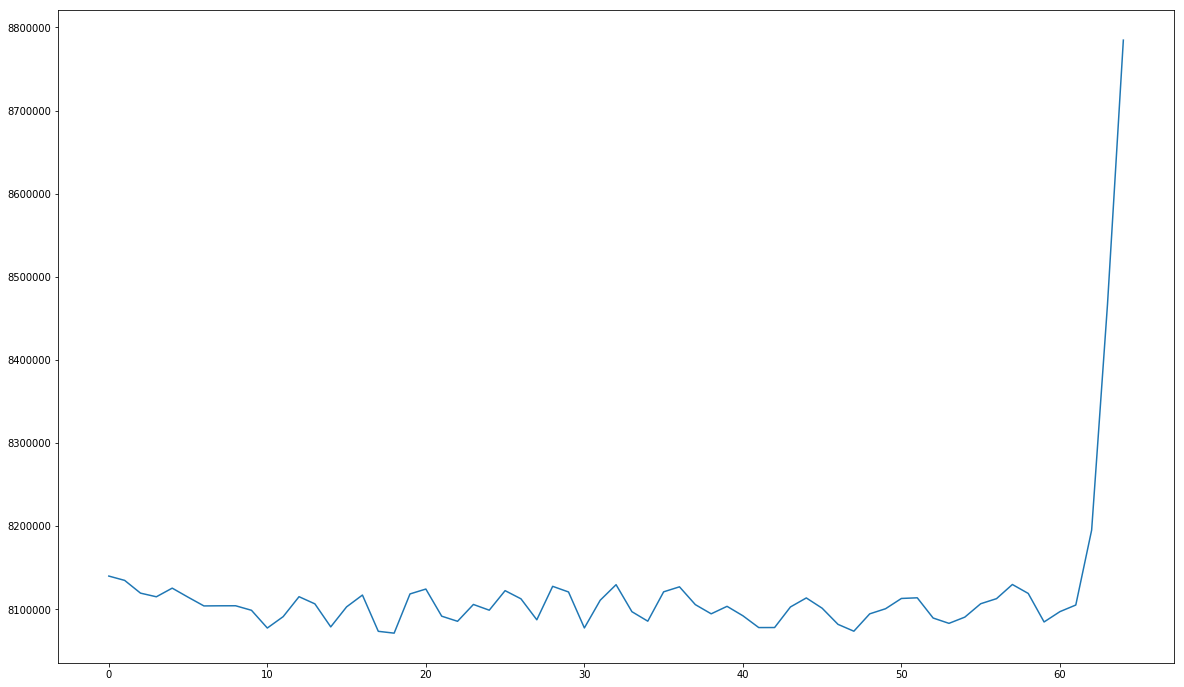

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


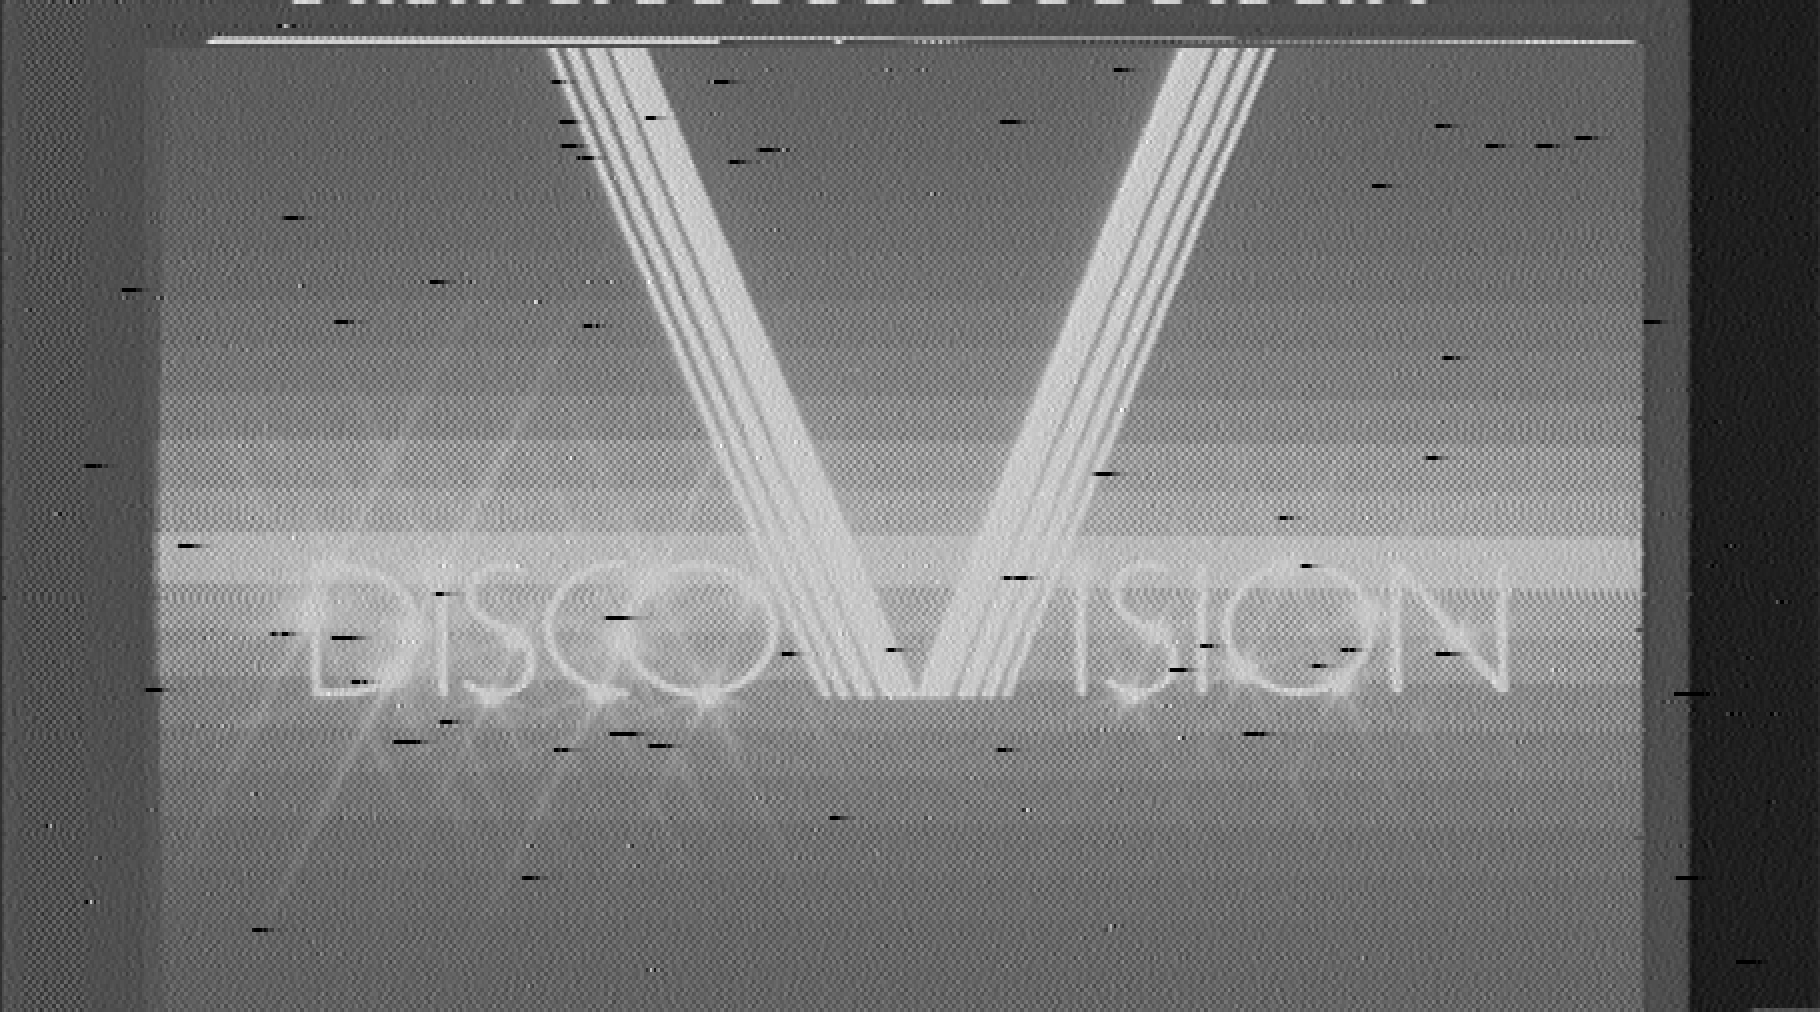

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

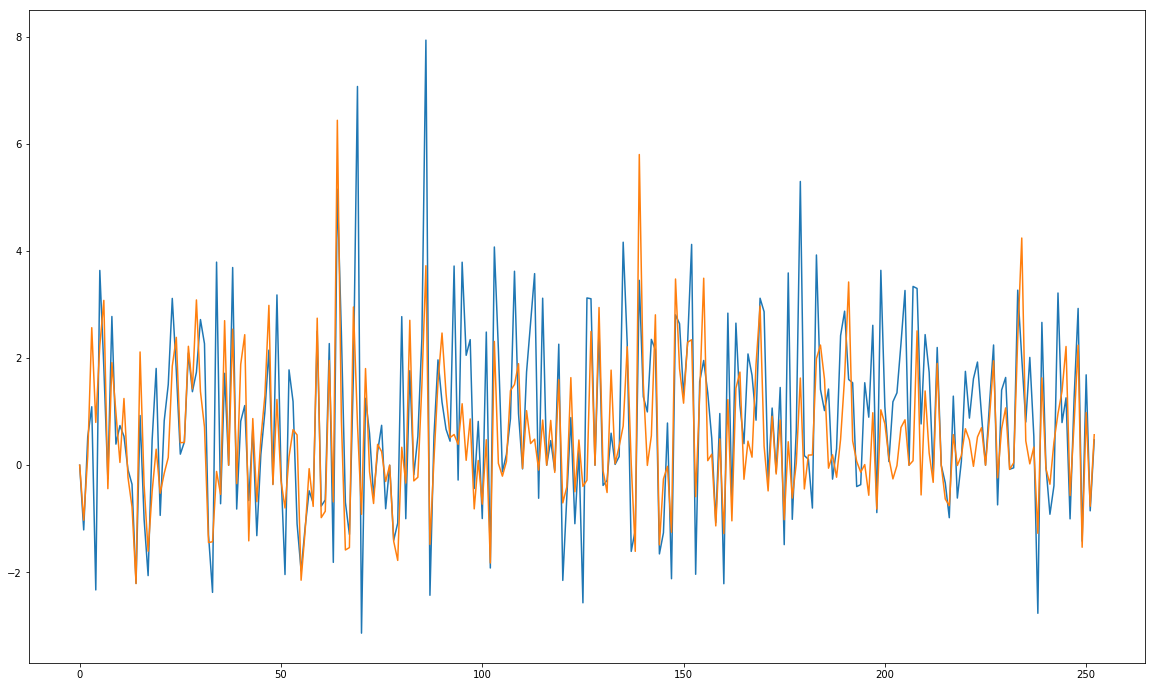

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

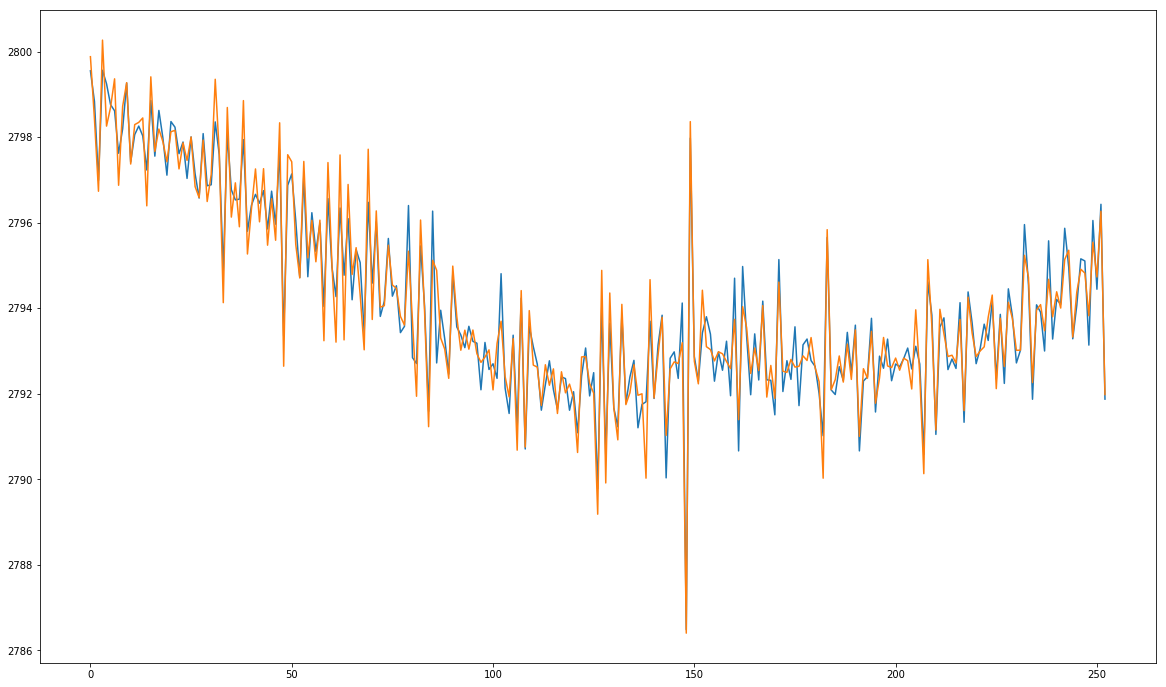

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))